In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#static dielectric constant of water
def static_dia_water(T):
    e_w0 = 88.045 - 0.4147*T + 6.295*1e-4*T**2 + 1.075e-5*T**3
    return e_w0

def chill_t_water(T):
    relax_t = (1.1109e-10 - 3.824e-12*T + 6.938e-14*T**2 - 5.096e-16*T**3) / (2*np.pi) # T in C
    return relax_t

def dielectric_water(f, T):
    e_inf = 4.9
    e_w0 = static_dia_water(T)
    rt = chill_t_water(T)

    test=e_inf+(e_w0-e_inf)/(1+np.pi*f*rt*2j)
    e_real=np.real(test)
    e_imag=np.imag(test)

    return e_real, e_imag


### Question 1

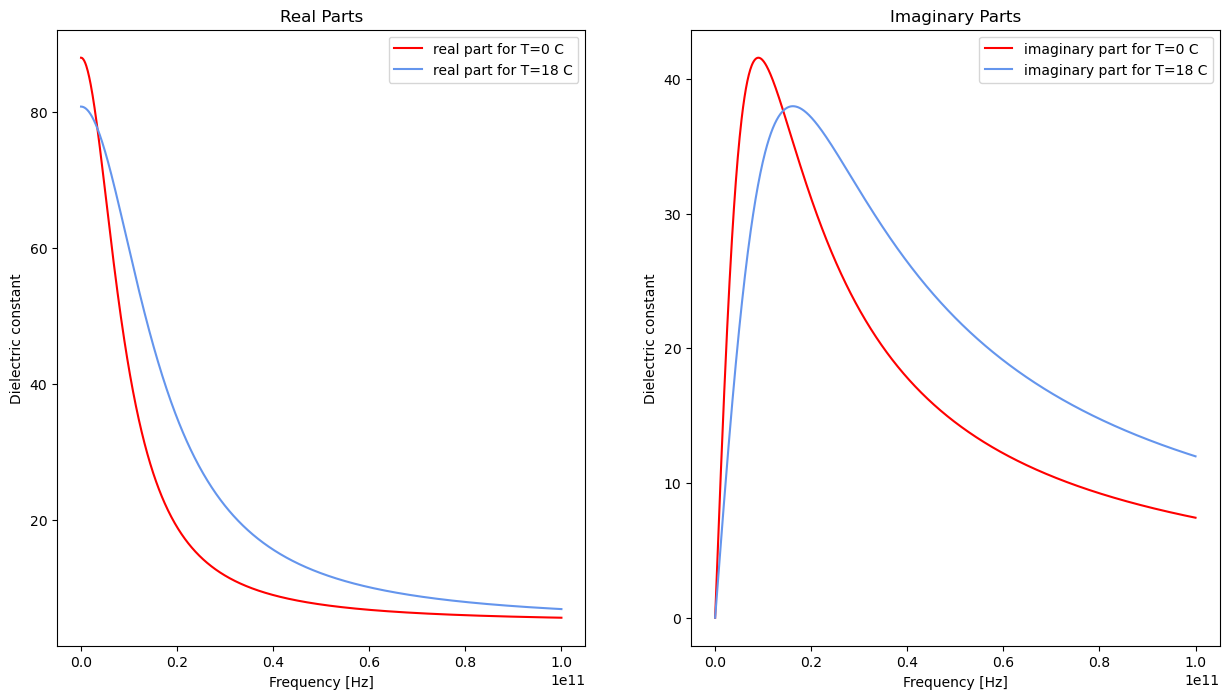

relax frq for T=0 9.00900900900901
relax frq for T=18 16.216216216216218


In [3]:
f = np.linspace(0, 100, 1000)*10**9


real_0,ima_0=dielectric_water(f,0)
real_18,ima_18=dielectric_water(f,18)

figure,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
ax1.plot(f,real_0,label='real part for T=0 C',color='red')
ax1.plot(f,real_18,label='real part for T=18 C',color='cornflowerblue')
ax1.set_title('Real Parts')
ax1.set_xlabel ('Frequency [Hz]')
ax1.set_ylabel ('Dielectric constant')
ax1.legend()

ax2.plot(f,-ima_0,label='imaginary part for T=0 C',color='red')
ax2.plot(f,-ima_18,label='imaginary part for T=18 C',color='cornflowerblue')
ax2.set_title('Imaginary Parts')
ax2.set_xlabel ('Frequency [Hz]')
ax2.set_ylabel ('Dielectric constant')
ax2.legend()

plt.show()

## Relaxation frequency
indx_1=np.argmin(ima_0)
indx_2=np.argmin(ima_18)

print('relax frq for T=0',f[indx_1]*10**(-9))
print('relax frq for T=18',f[indx_2]*10**(-9))



### Question 2

In [4]:
def soil_dialectric (T,frq,mv,S,C,rho_bulk = 1.54):

    # Get the values for water that is in the soil
    water_real,water_imaginary=dielectric_water(frq,T)

    e_w0 = static_dia_water(T)


    # Empirical relations for soil values
    alpha = 0.65
    beta_1 = 1.27 - 0.519*S - 0.152 * C
    beta_2 = 2.06 - 0.928*S - 0.255 * C
    sigma_eff = -1.645 +1.939*rho_bulk - 2.256 * S +1.594*C

    #Need to add the extra term in the imaginary part of water to compensate for the soil texture

    extra_term = (2.65-rho_bulk)/(2.65*mv) * sigma_eff/(2*np.pi*e_w0*frq)
    water_imaginary+=extra_term

    real_soil=(1+0.66*rho_bulk+mv**(beta_1) *water_real**(alpha) -mv )**(1/alpha)
    imaginary_soil=mv**(beta_2)*water_imaginary

    return real_soil, imaginary_soil


    

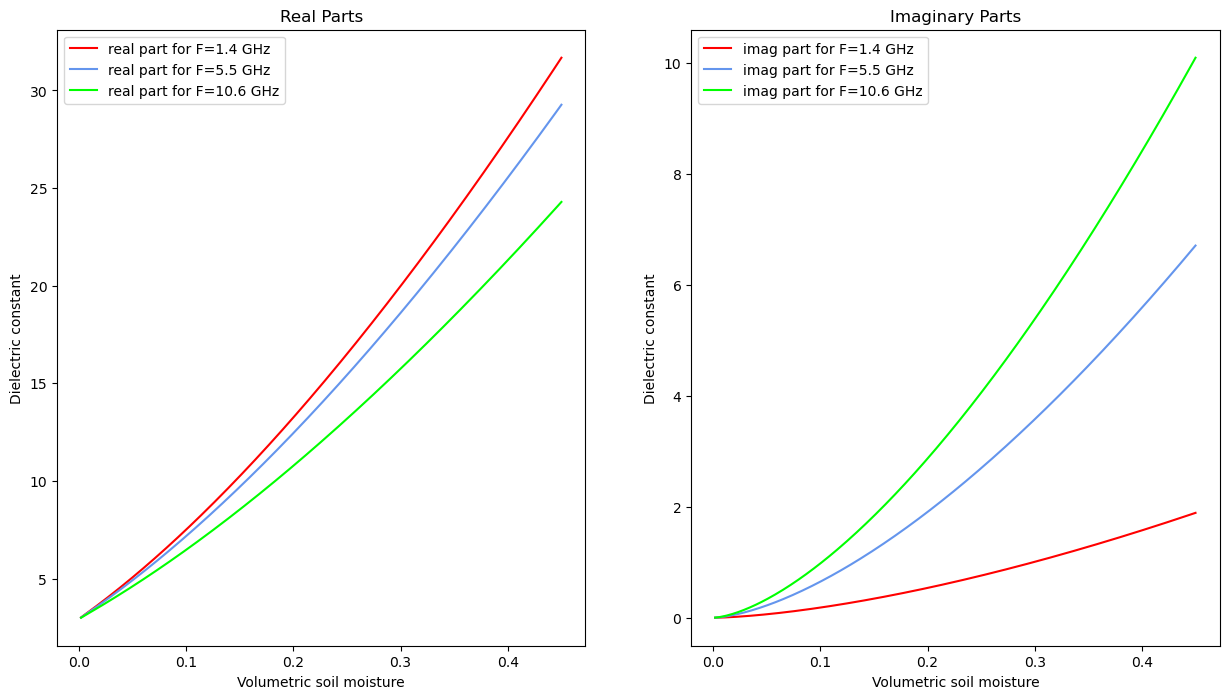

In [5]:
porosity=0.45
sand_frac = 0.51
clay_frac = 0.14
volumetric_soil_moisture = np.linspace(0,porosity,250)[1:]
T=18 #[C]
frequencies = np.array((1.4,5.5,10.6))*10**9

real_parts=[]
imaginary_parts=[]

for f in frequencies :
    real,imag=soil_dialectric(T,f,volumetric_soil_moisture,sand_frac,clay_frac)

    real_parts.append(real)
    imaginary_parts.append(imag)


figure,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))

ax1.plot(volumetric_soil_moisture,real_parts[0],label='real part for F=1.4 GHz',color='red')
ax1.plot(volumetric_soil_moisture,real_parts[1],label='real part for F=5.5 GHz',color='cornflowerblue')
ax1.plot(volumetric_soil_moisture,real_parts[2],label='real part for F=10.6 GHz',color='lime')
ax1.set_title('Real Parts')
ax1.set_xlabel ('Volumetric soil moisture')
ax1.set_ylabel ('Dielectric constant')
ax1.legend()

ax2.plot(volumetric_soil_moisture,-imaginary_parts[0],label='imag part for F=1.4 GHz',color='red')
ax2.plot(volumetric_soil_moisture,-imaginary_parts[1],label='imag part for F=5.5 GHz',color='cornflowerblue')
ax2.plot(volumetric_soil_moisture,-imaginary_parts[2],label='imag part for F=10.6 GHz',color='lime')
ax2.set_xlabel ('Volumetric soil moisture')
ax2.set_ylabel ('Dielectric constant')
ax2.set_title('Imaginary Parts')

ax2.legend()

plt.show()


### Question 3

In [6]:
# Smooth surface equations 
# Calculate the Fresnel reflection coefficients, then the reflectivity and with that the emissivity
def emmisivity_vv_smooth (theta, T,frq,mv,S,C):
    real_e, imag_e = soil_dialectric(T,frq,mv,S,C)
    e=real_e-imag_e*1j
    R_vv = (e * np.cos(theta) - np.sqrt (e - np.sin(theta)**2)) / (e * np.cos(theta) + np.sqrt (e - np.sin(theta)**2))
    rho_vv = np.abs (R_vv)**2
    emissivity_smooth = 1 - rho_vv
    return emissivity_smooth

def emissivity_hh_smooth (theta, T,frq,mv,S,C):
    real_e, imag_e = soil_dialectric(T,frq,mv,S,C)
    e=real_e-imag_e*1j
    R_hh = (np.cos(theta) - np.sqrt (e - np.sin(theta)**2)) / (np.cos(theta) + np.sqrt (e - np.sin(theta)**2))
    rho_hh = np.abs (R_hh)**2
    emissivity_smooth = 1 - rho_hh
    return emissivity_smooth



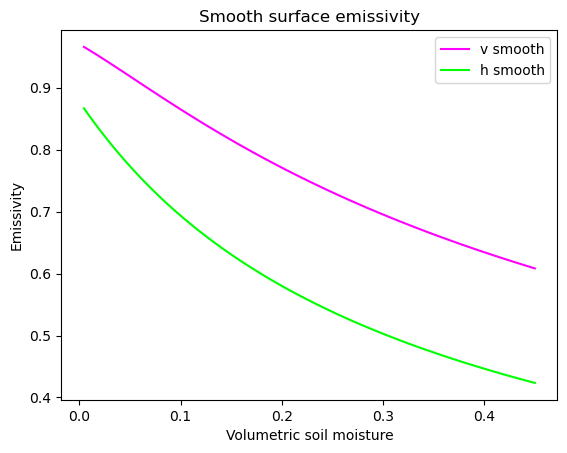

In [7]:
# Plot the results 
mv=np.linspace(0,0.45,100)[1:]
incident_angle=np.radians(40)
smooth_vv = emmisivity_vv_smooth(incident_angle,T,frequencies[0],mv,sand_frac,clay_frac)
smooth_hh = emissivity_hh_smooth(incident_angle,T,frequencies[0],mv,sand_frac,clay_frac)

plt.plot(mv,smooth_vv,color='magenta',label='v smooth')
plt.plot(mv,smooth_hh,color='lime',label='h smooth')
plt.xlabel('Volumetric soil moisture')
plt.ylabel('Emissivity')
plt.title ('Smooth surface emissivity')
plt.legend()
plt.show()




### Time for some Rough Surface calculations

In [8]:
# Rough surface emissivity equations 
def emmisivity_vv_rough (theta, T,frq,mv,S,C, h):
    real_e, imag_e = soil_dialectric(T,frq,mv,S,C)
    e=real_e-imag_e*1j
    R_vv = (e * np.cos(theta) - np.sqrt (e - np.sin(theta)**2)) / (e * np.cos(theta) + np.sqrt (e - np.sin(theta)**2))
    rho_vv = np.abs (R_vv)**2
    rho_vv_rough = rho_vv * np.exp (-h * np.cos(theta)) 
    emissivity_vv_rough = 1 - rho_vv_rough
    return emissivity_vv_rough

def emissivity_hh_rough (theta, T,frq,mv,S,C, h):
    real_e, imag_e = soil_dialectric(T,frq,mv,S,C)
    e=real_e-imag_e*1j
    R_hh = (np.cos(theta) - np.sqrt (e - np.sin(theta)**2)) / (np.cos(theta) + np.sqrt (e - np.sin(theta)**2))
    rho_hh = np.abs (R_hh)**2
    rho_hh_rough = rho_hh * np.exp (-h * np.cos(theta)) 
    emissivity_hh_rough = 1 - rho_hh_rough
    return emissivity_hh_rough



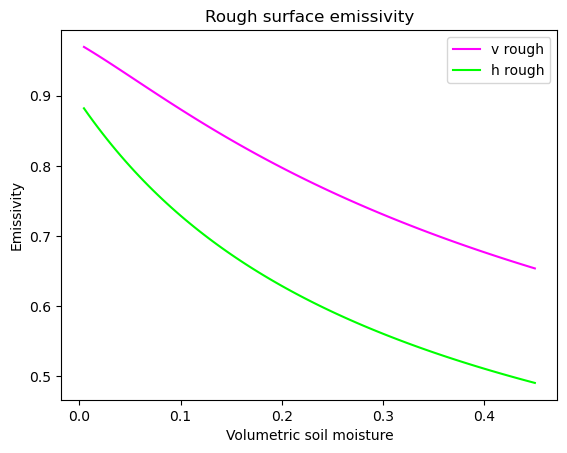

In [9]:
h=0.16

rough_vv = emmisivity_vv_rough(incident_angle,T,frequencies[0],mv,sand_frac,clay_frac,h)
rough_hh = emissivity_hh_rough(incident_angle,T,frequencies[0],mv,sand_frac,clay_frac,h)


plt.plot(mv,rough_vv,color='magenta',label='v rough')
plt.plot(mv,rough_hh,color='lime',label='h rough')
plt.xlabel('Volumetric soil moisture')
plt.ylabel('Emissivity')
plt.title ('Rough surface emissivity')
plt.legend()


plt.show()

plt.show()

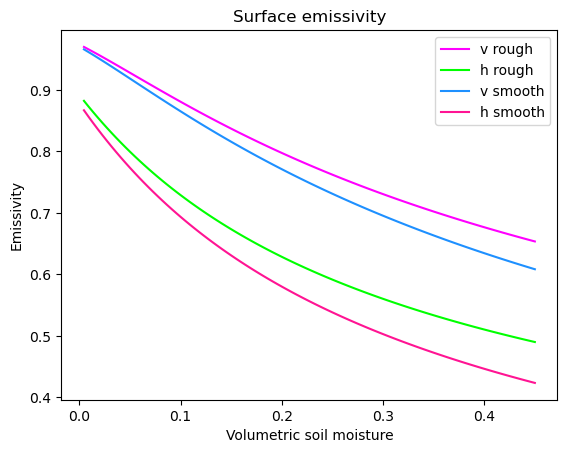

In [10]:
plt.plot(mv,rough_vv,color='magenta',label='v rough')
plt.plot(mv,rough_hh,color='lime',label='h rough')
plt.plot(mv,smooth_vv,color='dodgerblue',label='v smooth')
plt.plot(mv,smooth_hh,color='deeppink',label='h smooth')
plt.xlabel('Volumetric soil moisture')
plt.ylabel('Emissivity')
plt.title ('Surface emissivity')
plt.legend()

## Brightness temperature

In [11]:
def compute_TB_p(epsilon_s_p, T_s, gamma, omega, T_v):
    ''
    'Omega is single scattering albedo'
    'Gamma is Opacity'
    ''
    #attenuated surface emission
    term1 = epsilon_s_p * T_s * gamma

    #direct volume emission
    term2 = (1 - omega) * (1 - gamma) * T_v

    #scattered volume emission
    term3 = (1 - epsilon_s_p) * (1 - omega) * (1 - gamma) * T_v * gamma
    return term1 , term2 , term3


def gamma_opacity(b, VWC, theta):
    ''
    'b is some parameter'
    'VWC is vegetation water content'
    ''
    tau = b * VWC
    opacity_gamma = np.exp(-tau/ np.cos(theta))
    return opacity_gamma

#### For bare soil

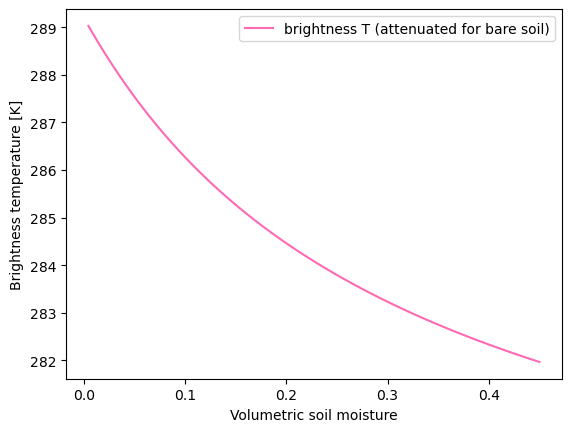

In [12]:
Ts=18
b=0.11
single_scattering_albedo=0.05

gamma=gamma_opacity(b,0,incident_angle)

t1,t2,t3=compute_TB_p(rough_hh, Ts, gamma, single_scattering_albedo, Ts)
bare_soil=t1+t2+t3

plt.figure()
plt.plot(mv,bare_soil+273.15,color='hotpink',label='brightness T (attenuated for bare soil)')
plt.xlabel('Volumetric soil moisture')
plt.ylabel('Brightness temperature [K]')
plt.legend()
plt.show()


### For veggy soil

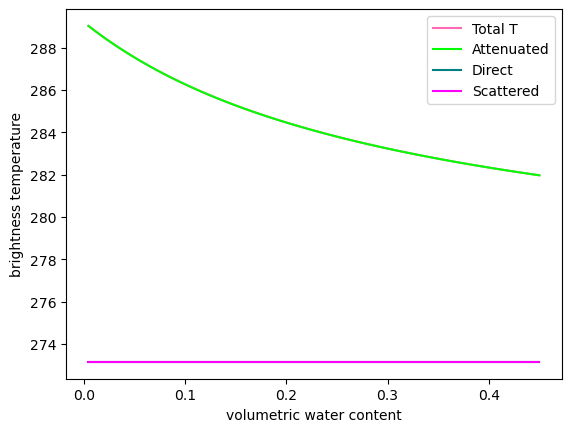

In [13]:
gamma_5=gamma_opacity(b,5,incident_angle)

t1_5,t2_5,t3_5=compute_TB_p(rough_hh, Ts, gamma_5, single_scattering_albedo, Ts)
bare_soil_5=t1_5+t2_5+t3_5

plt.figure()
plt.plot(mv,bare_soil+273.15,color='hotpink',label='Total T')
plt.plot(mv,t1+273.15,color='lime',label='Attenuated')
plt.plot(mv,t2+np.zeros(len(mv))+273.15,color='teal',label='Direct')
plt.plot(mv,t3+273.15,color='magenta',label='Scattered')

plt.xlabel('volumetric water content')
plt.ylabel('brightness temperature')
plt.legend()
plt.show()

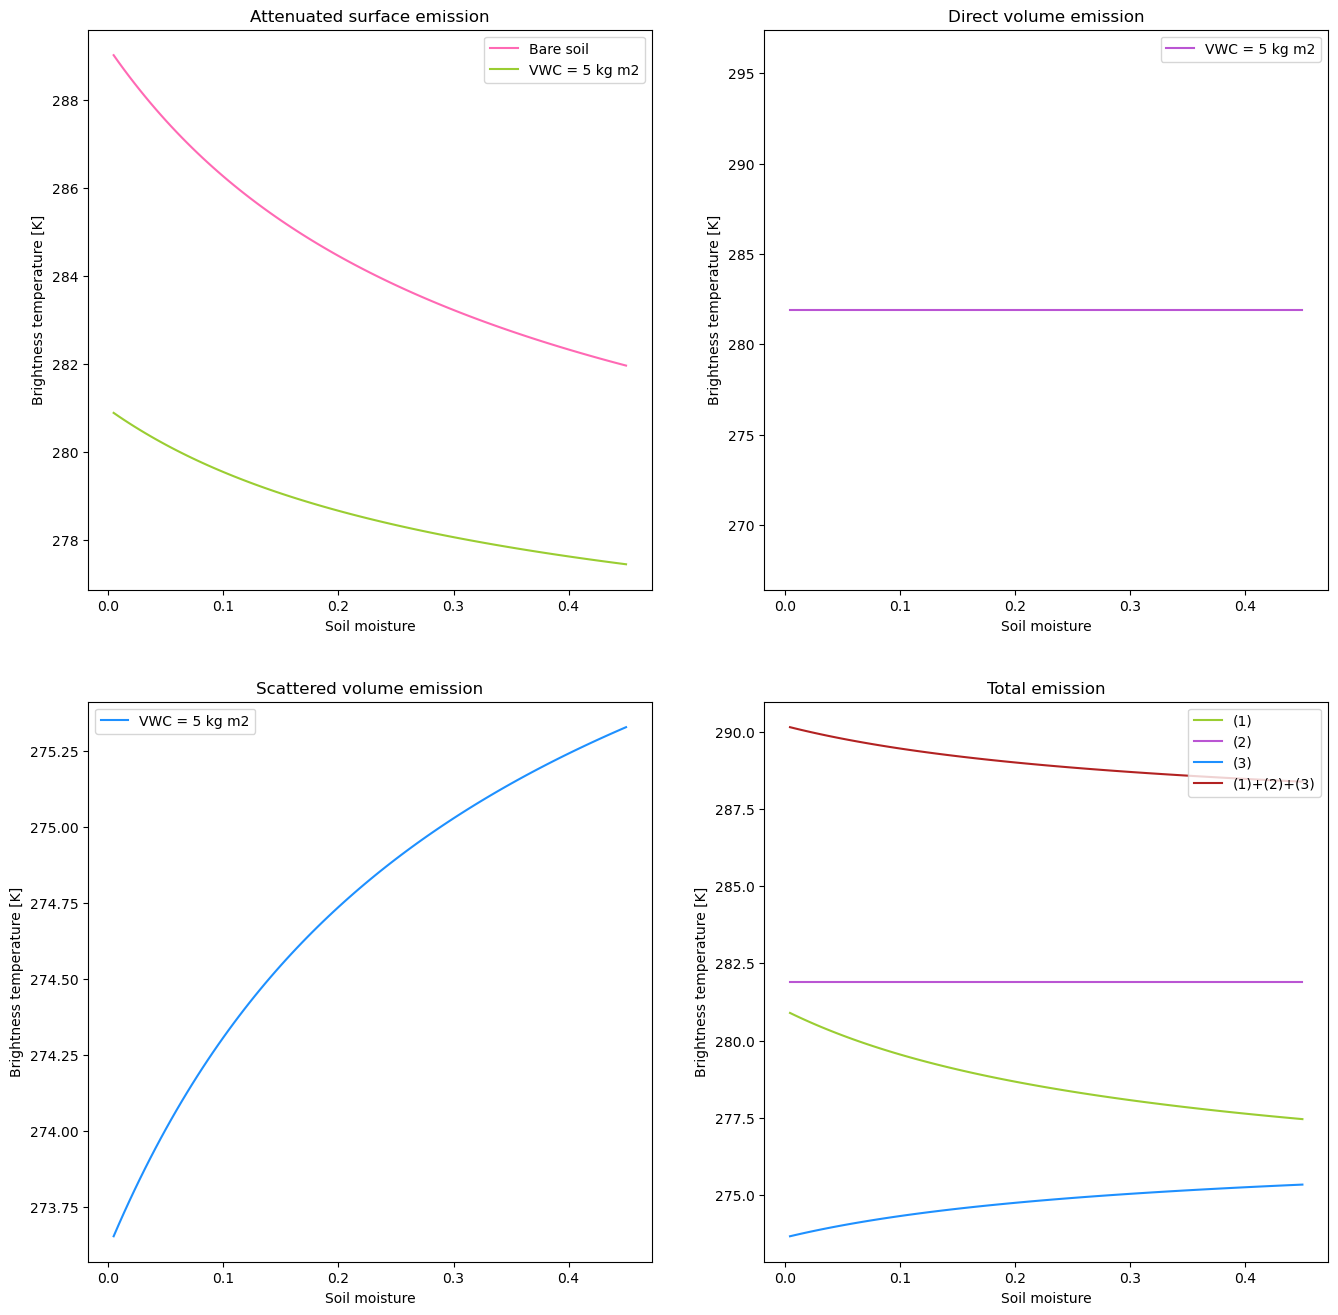

In [14]:
# Create the figure from the assignment 

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

axes[0,0].plot(mv,t1+273.15,color='hotpink',label='Bare soil')
axes[0,0].plot(mv,t1_5+273.15,color='yellowgreen',label='VWC = 5 kg m2')
axes[0,0].set_title('Attenuated surface emission')
axes[0,0].set_xlabel('Soil moisture')
axes[0,0].set_ylabel('Brightness temperature [K]')
axes[0,0].legend()

axes[0,1].plot(mv,t2_5+np.zeros(len(mv))+273.15,color='mediumorchid',label='VWC = 5 kg m2')
axes[0,1].set_title('Direct volume emission')
axes[0,1].set_xlabel('Soil moisture')
axes[0,1].set_ylabel('Brightness temperature [K]')
axes[0,1].legend()

axes[1,0].plot(mv,t3_5+273.15,color='dodgerblue',label='VWC = 5 kg m2')
axes[1,0].set_title('Scattered volume emission')
axes[1,0].set_xlabel('Soil moisture')
axes[1,0].set_ylabel('Brightness temperature [K]')
axes[1,0].legend()

axes[1,1].plot(mv,t1_5+273.15,color='yellowgreen',label='(1)')
axes[1,1].plot(mv,t2_5+np.zeros(len(mv))+273.15,color='mediumorchid',label='(2)')
axes[1,1].plot(mv,t3_5+273.15,color='dodgerblue',label='(3)')
axes[1,1].plot(mv,(t1_5+t2_5+np.zeros(len(mv))+t3_5)+273.15,color='firebrick',label='(1)+(2)+(3)')
axes[1,1].set_title('Total emission')
axes[1,1].set_xlabel('Soil moisture')
axes[1,1].set_ylabel('Brightness temperature [K]')
axes[1,1].legend()

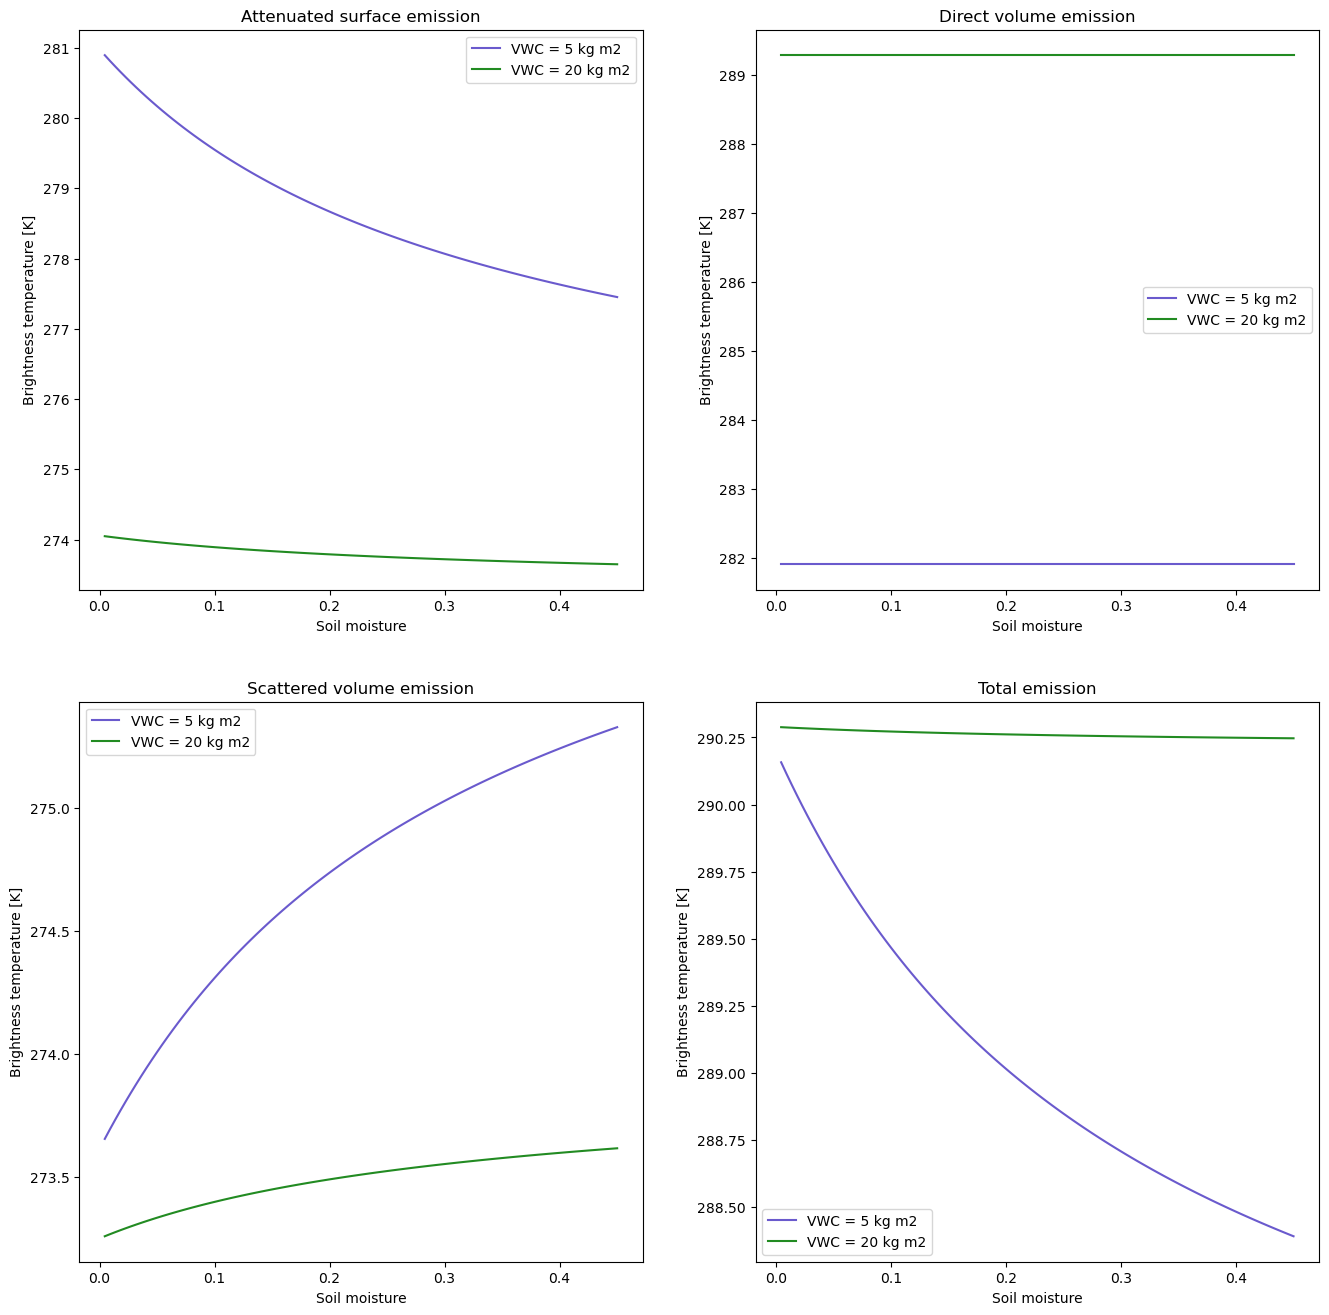

In [15]:
# 5 vs 20 plot 
gamma_20=gamma_opacity(b,20,incident_angle)

t1_20,t2_20,t3_20=compute_TB_p(rough_hh, Ts, gamma_20, single_scattering_albedo, Ts)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

axes[0,0].plot(mv,t1_5+273.15,color='slateblue',label='VWC = 5 kg m2')
axes[0,0].plot(mv,t1_20+273.15,color='forestgreen',label='VWC = 20 kg m2')
axes[0,0].set_title('Attenuated surface emission')
axes[0,0].set_xlabel('Soil moisture')
axes[0,0].set_ylabel('Brightness temperature [K]')
axes[0,0].legend()

axes[0,1].plot(mv,t2_5+np.zeros(len(mv))+273.15,color='slateblue',label='VWC = 5 kg m2')
axes[0,1].plot(mv,t2_20+np.zeros(len(mv))+273.15,color='forestgreen',label='VWC = 20 kg m2')
axes[0,1].set_title('Direct volume emission')
axes[0,1].set_xlabel('Soil moisture')
axes[0,1].set_ylabel('Brightness temperature [K]')
axes[0,1].legend()

axes[1,0].plot(mv,t3_5+273.15,color='slateblue',label='VWC = 5 kg m2')
axes[1,0].plot(mv,t3_20+273.15,color='forestgreen',label='VWC = 20 kg m2')
axes[1,0].set_title('Scattered volume emission')
axes[1,0].set_xlabel('Soil moisture')
axes[1,0].set_ylabel('Brightness temperature [K]')
axes[1,0].legend()

axes[1,1].plot(mv,(t1_5+t2_5+np.zeros(len(mv))+t3_5)+273.15,color='slateblue',label='VWC = 5 kg m2')
axes[1,1].plot(mv,(t1_20+t2_20+np.zeros(len(mv))+t3_20)+273.15,color='forestgreen',label='VWC = 20 kg m2')
axes[1,1].set_title('Total emission')
axes[1,1].set_xlabel('Soil moisture')
axes[1,1].set_ylabel('Brightness temperature [K]')
axes[1,1].legend()